# Data Modelling

Since as of now I only know KNN, Logistic Regression and Decision Tree Classifiers, I wil stick to those for time being. Also I will employ GridSearchCV to figure out the best parameters for each algorithm

In [1]:
# create a custom vectorizer class
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

class CustomVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, method='count', **kwargs):
        """
        Custom vectorizer that can switch between CountVectorizer and TfidfVectorizer.
        
        Parameters:
        - method: 'count' for CountVectorizer or 'tfidf' for TfidfVectorizer
        - kwargs: Additional parameters to be passed to the vectorizer
        """
        self.method = method
        self.kwargs = kwargs
        self.vectorizer = None

    def get_params(self, deep=True):
        """Return parameters for this estimator."""
        params = {"method": self.method}
        params.update(self.kwargs)
        return params

    def set_params(self, **params):
        """Set parameters for this estimator."""
        if "method" in params:
            self.method = params.pop("method")
        self.kwargs.update(params)
        return self

    def fit(self, X, y=None):
        # Initialize the vectorizer based on the selected method
        if self.method == 'count':
            self.vectorizer = CountVectorizer(**self.kwargs)
        elif self.method == 'tfidf':
            self.vectorizer = TfidfVectorizer(**self.kwargs)
        else:
            raise ValueError("Invalid method. Choose 'count' or 'tfidf'.")

        # Fit the vectorizer
        self.vectorizer.fit(X)
        return self

    def transform(self, X):
        # Transform the data using the chosen vectorizer
        if not self.vectorizer:
            raise ValueError("Vectorizer not initialized. Call fit() first.")
        return self.vectorizer.transform(X)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)


0.42857142857142855
                    precision    recall  f1-score   support

      #AEWDynamite       0.00      0.00      0.00         8
          #AskAiah       0.00      0.00      0.00         2
            #BBMAs       1.00      0.67      0.80         9
          #CUTOSHI       1.00      0.57      0.73         7
         #GSWvsHOU       0.50      0.29      0.36         7
          #PMSLive       0.67      0.25      0.36         8
           #RHOSLC       0.62      0.62      0.62         8
       #Survivor47       0.83      0.62      0.71         8
       #TNFonPrime       0.40      0.25      0.31         8
    #TheGameAwards       0.20      0.12      0.15         8
        #WhyIChime       1.00      0.67      0.80         6
          #liftoff       1.00      0.14      0.25         7
#playstationwrapup       0.50      0.50      0.50         8
 #thursdaythoughts       0.22      0.67      0.33        18

          accuracy                           0.43       112
         macro avg

/Users/amandeep/Code/GitHub/adchawla/kraftwerk/04_CapstoneProject_GenerationOfRelevantHashTagsForSocialMediaPosts/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/amandeep/Code/GitHub/adchawla/kraftwerk/04_CapstoneProject_GenerationOfRelevantHashTagsForSocialMediaPosts/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/amandeep/Code/GitHub/adchawla/kraftwerk/04_CapstoneProject_GenerationOfRelevantHashTagsForSocialMediaPosts/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification

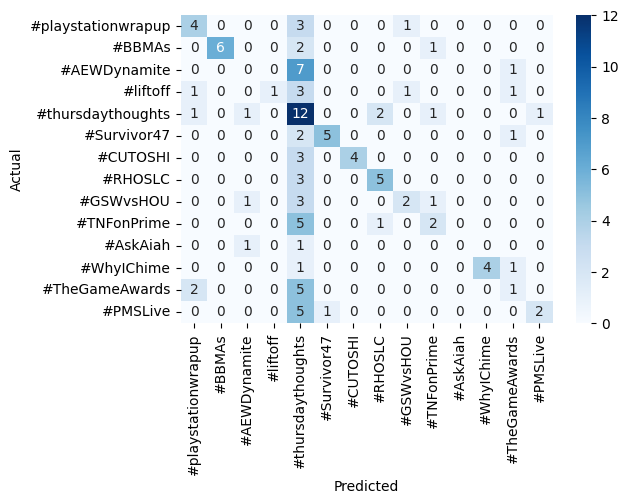

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

# Load the embedded dataset
file_path = './data/embedded_all_tweets.csv'  # Update path as needed
embedded_data = pd.read_csv(file_path)

pd.DataFrame({'model': ['Logistic', 'Decision Tree', 'Bayes'], 
             'best_params': ['', '', ''],
             'best_score': ['', '', '']}).set_index('model')


from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = embedded_data['processed_text']
y = embedded_data['hashtag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Create a pipeline with a custom processor and a custom vectorizer
pipe = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', max_features=100)),
    ('model', LogisticRegression(multi_class='multinomial', max_iter=1000))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# plot the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred, labels=y.unique())
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=y.unique(), yticklabels=y.unique())
#plt.title(f"Confusion Matrix for {name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Various models with Grid Search CV to figure out the best parameters


Running GridSearchCV for Logistic Regression


/Users/amandeep/Code/GitHub/adchawla/kraftwerk/04_CapstoneProject_GenerationOfRelevantHashTagsForSocialMediaPosts/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/amandeep/Code/GitHub/adchawla/kraftwerk/04_CapstoneProject_GenerationOfRelevantHashTagsForSocialMediaPosts/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/amandeep/Code/GitHub/adchawla/kraftwerk/04_CapstoneProject_GenerationOfRelevantHashTagsForSocialMediaPosts/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: Futur

... completed in 3.56 seconds
Running GridSearchCV for Decision Tree
... completed in 0.42 seconds
Running GridSearchCV for KNN
... completed in 0.18 seconds
Running GridSearchCV for Naive Bayes
... completed in 0.10 seconds
{'#AEWDynamite': {'precision': 1.0, 'recall': 0.375, 'f1-score': 0.5454545454545454, 'support': 8.0}, '#AskAiah': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 2.0}, '#BBMAs': {'precision': 1.0, 'recall': 0.7777777777777778, 'f1-score': 0.875, 'support': 9.0}, '#CUTOSHI': {'precision': 0.7142857142857143, 'recall': 0.7142857142857143, 'f1-score': 0.7142857142857143, 'support': 7.0}, '#GSWvsHOU': {'precision': 1.0, 'recall': 0.2857142857142857, 'f1-score': 0.4444444444444444, 'support': 7.0}, '#PMSLive': {'precision': 0.42857142857142855, 'recall': 0.375, 'f1-score': 0.4, 'support': 8.0}, '#RHOSLC': {'precision': 0.7777777777777778, 'recall': 0.875, 'f1-score': 0.8235294117647058, 'support': 8.0}, '#Survivor47': {'precision': 0.8571428571428571, 'rec

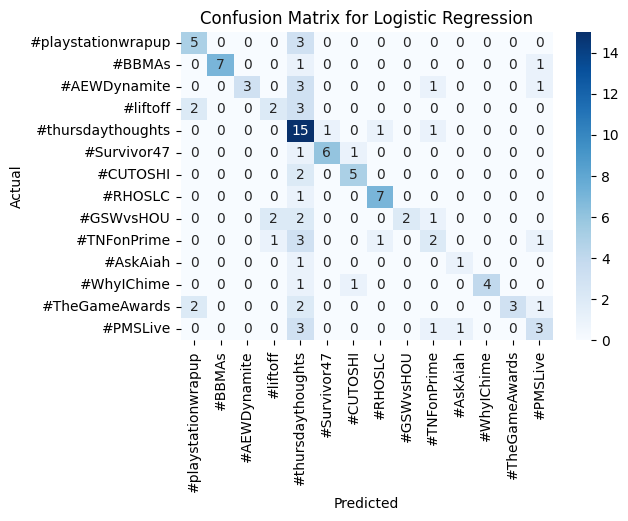

{'#AEWDynamite': {'precision': 0.6666666666666666, 'recall': 0.25, 'f1-score': 0.36363636363636365, 'support': 8.0}, '#AskAiah': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 2.0}, '#BBMAs': {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 9.0}, '#CUTOSHI': {'precision': 0.5555555555555556, 'recall': 0.7142857142857143, 'f1-score': 0.625, 'support': 7.0}, '#GSWvsHOU': {'precision': 0.75, 'recall': 0.42857142857142855, 'f1-score': 0.5454545454545454, 'support': 7.0}, '#PMSLive': {'precision': 0.2857142857142857, 'recall': 0.25, 'f1-score': 0.26666666666666666, 'support': 8.0}, '#RHOSLC': {'precision': 1.0, 'recall': 0.875, 'f1-score': 0.9333333333333333, 'support': 8.0}, '#Survivor47': {'precision': 0.875, 'recall': 0.875, 'f1-score': 0.875, 'support': 8.0}, '#TNFonPrime': {'precision': 0.5714285714285714, 'recall': 0.5, 'f1-score': 0.5333333333333333, 'support': 8.0}, '#TheGameAwards': {'precision': 1.0, 'recall': 0.125, 'f1-score': 0.2222222

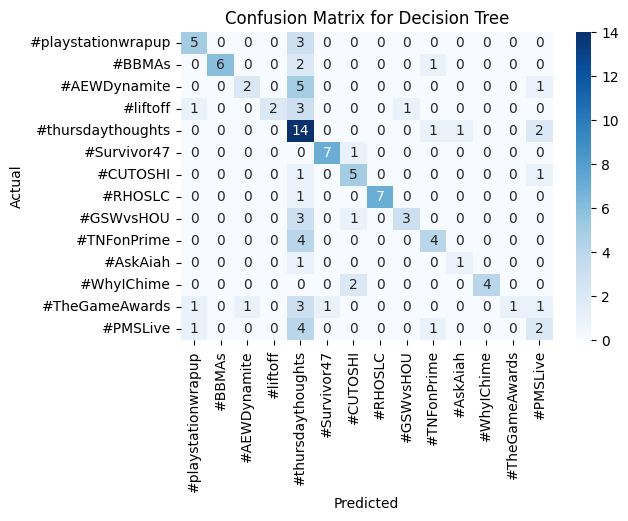

{'#AEWDynamite': {'precision': 0.75, 'recall': 0.375, 'f1-score': 0.5, 'support': 8.0}, '#AskAiah': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 2.0}, '#BBMAs': {'precision': 0.8, 'recall': 0.8888888888888888, 'f1-score': 0.8421052631578947, 'support': 9.0}, '#CUTOSHI': {'precision': 0.8571428571428571, 'recall': 0.8571428571428571, 'f1-score': 0.8571428571428571, 'support': 7.0}, '#GSWvsHOU': {'precision': 0.42857142857142855, 'recall': 0.42857142857142855, 'f1-score': 0.42857142857142855, 'support': 7.0}, '#PMSLive': {'precision': 0.6666666666666666, 'recall': 0.5, 'f1-score': 0.5714285714285714, 'support': 8.0}, '#RHOSLC': {'precision': 0.7, 'recall': 0.875, 'f1-score': 0.7777777777777778, 'support': 8.0}, '#Survivor47': {'precision': 0.5714285714285714, 'recall': 1.0, 'f1-score': 0.7272727272727273, 'support': 8.0}, '#TNFonPrime': {'precision': 0.36363636363636365, 'recall': 0.5, 'f1-score': 0.42105263157894735, 'support': 8.0}, '#TheGameAwards': {'precision': 0.66

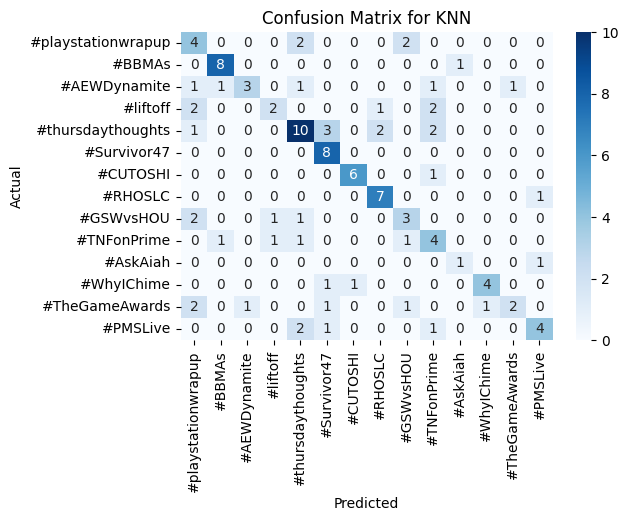

{'#AEWDynamite': {'precision': 1.0, 'recall': 0.375, 'f1-score': 0.5454545454545454, 'support': 8.0}, '#AskAiah': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2.0}, '#BBMAs': {'precision': 0.8, 'recall': 0.8888888888888888, 'f1-score': 0.8421052631578947, 'support': 9.0}, '#CUTOSHI': {'precision': 0.8571428571428571, 'recall': 0.8571428571428571, 'f1-score': 0.8571428571428571, 'support': 7.0}, '#GSWvsHOU': {'precision': 1.0, 'recall': 0.42857142857142855, 'f1-score': 0.6, 'support': 7.0}, '#PMSLive': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 8.0}, '#RHOSLC': {'precision': 0.7777777777777778, 'recall': 0.875, 'f1-score': 0.8235294117647058, 'support': 8.0}, '#Survivor47': {'precision': 0.6666666666666666, 'recall': 1.0, 'f1-score': 0.8, 'support': 8.0}, '#TNFonPrime': {'precision': 0.25, 'recall': 0.125, 'f1-score': 0.16666666666666666, 'support': 8.0}, '#TheGameAwards': {'precision': 0.75, 'recall': 0.375, 'f1-score': 0.5, 'support': 8.0}, '#WhyICh

/Users/amandeep/Code/GitHub/adchawla/kraftwerk/04_CapstoneProject_GenerationOfRelevantHashTagsForSocialMediaPosts/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/amandeep/Code/GitHub/adchawla/kraftwerk/04_CapstoneProject_GenerationOfRelevantHashTagsForSocialMediaPosts/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/amandeep/Code/GitHub/adchawla/kraftwerk/04_CapstoneProject_GenerationOfRelevantHashTagsForSocialMediaPosts/.venv/lib/python3.10/site-packages

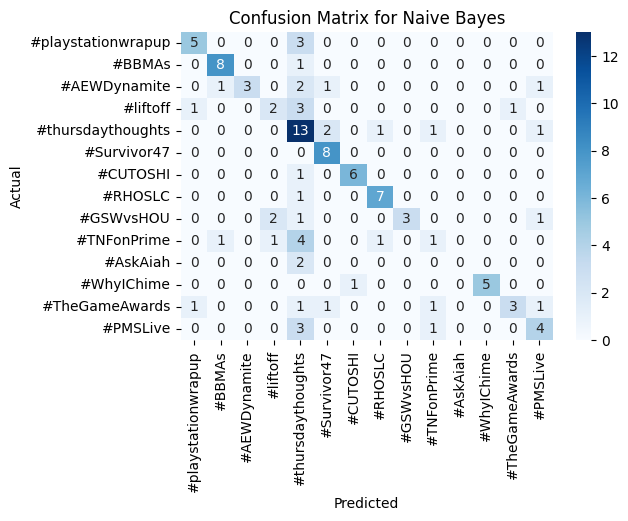

,Best Parameters,Training Score,Test Score,Mean Fit Time,Mean Test Time
Model,,,,,
Logistic Regression,"{'classifier__C': 10, 'classifier__solver': 's...",0.574324,0.580357,0.117910,0.002699
Decision Tree,"{'classifier__max_depth': None, 'classifier__m...",0.490991,0.562500,0.007843,0.002414
KNN,"{'classifier__n_neighbors': 5, 'classifier__we...",0.542793,0.589286,0.004979,0.003989
Naive Bayes,"{'classifier__alpha': 0.1, 'vectorizer__max_fe...",0.565315,0.607143,0.005256,0.002046


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import time

# suppress warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

params = {
    'vectorizer__method': ['tfidf', 'count'],
    'vectorizer__stop_words': ['english', None],
    'vectorizer__max_features': [100, 500, None]
}

pipelines = {
    'Logistic Regression': Pipeline([
        ('vectorizer', CustomVectorizer()),
        ('classifier', LogisticRegression(max_iter=1000, multi_class='ovr'))
    ]),
    'Decision Tree': Pipeline([
        ('vectorizer', CustomVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ]),
    'KNN': Pipeline([
        ('vectorizer', CustomVectorizer()),
        ('classifier', KNeighborsClassifier())
    ]),
    'Naive Bayes': Pipeline([
        ('vectorizer', CustomVectorizer()),
        ('classifier', MultinomialNB())
    ])
}

def copy_and_update(d, new_values):
    new_dict = d.copy()
    new_dict.update(new_values)
    return new_dict

# Logistic Regression
param_grid_lr = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['lbfgs', 'saga']
}
param_grid_dt = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0]  # Smoothing parameter
}

param_grids = {
    'Logistic Regression': copy_and_update(params, param_grid_lr),
    'Decision Tree': copy_and_update(params, param_grid_dt),
    'KNN': copy_and_update(params, param_grid_knn),
    'Naive Bayes': copy_and_update(params, {'classifier__alpha': [0.1, 1.0, 10.0]})
}

# Running GridSearchCV for each pipeline
grid_search_results = {}
for name, pipeline in pipelines.items():
    print(f'Running GridSearchCV for {name}')
    # note the time taken to run the grid search
    start_time = time.time()
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=3, scoring='f1_micro', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    print(f'... completed in {end_time - start_time:.2f} seconds')
    grid_search_results[name] = grid_search

hashtags = embedded_data['hashtag'].unique()

# Collecting results for comparison
results_summary = []
for name, grid_search in grid_search_results.items():
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    test_score = grid_search.score(X_test, y_test)
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred, output_dict=True))
    mean_fit_time = grid_search.cv_results_['mean_fit_time'].mean()
    mean_score_time = grid_search.cv_results_['mean_score_time'].mean()
    results_summary.append((name, best_params, best_score, test_score, mean_fit_time, mean_score_time))
    cm = confusion_matrix(y_test, y_pred, labels=hashtags)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=hashtags, yticklabels=hashtags)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Converting the results to a DataFrame for better presentation
results_df = pd.DataFrame(results_summary, columns=['Model', 'Best Parameters', 'Training Score', 'Test Score', 'Mean Fit Time', 'Mean Test Time'])

results_df.set_index('Model', inplace=True)
results_df

In [4]:
# Using BERT embeddings

file_path = './data/embedded_all_tweets.csv'  # Update path as needed
embedded_data = pd.read_csv(file_path)

# Convert BERT embeddings from string to numerical arrays
embedded_data['bert_embedding'] = embedded_data['bert_embedding'].apply(
    lambda x: np.array([float(i) for i in x.strip('[]').split()])
)
# Prepare features (BERT embeddings)
X = np.vstack(embedded_data['bert_embedding'])

# Prepare targets (multi-label binary format for hashtags)
unique_hashtags = embedded_data['hashtag'].unique()
mlb = MultiLabelBinarizer(classes=unique_hashtags)
y = embedded_data['hashtag'] # mlb.fit_transform(embedded_data['hashtag'].apply(lambda x: [x] if isinstance(x, str) else []))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Initialize a results list
results = []

# Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'saga']
}
logistic_model = LogisticRegression(max_iter=1000, multi_class='ovr')
grid_search_lr = GridSearchCV(logistic_model, param_grid_lr, cv=3, scoring='f1_micro', n_jobs=-1, return_train_score=True)
grid_search_lr.fit(X_train, y_train)
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)
results.append({
    'Model': 'Logistic Regression (BERT)',
    'Best Parameters': grid_search_lr.best_params_,
    'Training Score': grid_search_lr.best_score_,
    'Test Score': classification_report(y_test, y_pred_lr, output_dict=True)['accuracy'],
    'Mean Fit Time': grid_search_lr.cv_results_['mean_fit_time'].mean(),
    'Mean Test Time': grid_search_lr.cv_results_['mean_score_time'].mean()
})

# Decision Tree
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
decision_tree = DecisionTreeClassifier()
grid_search_dt = GridSearchCV(decision_tree, param_grid_dt, cv=3, scoring='f1_micro', n_jobs=-1, return_train_score=True)
grid_search_dt.fit(X_train, y_train)
best_dt_model = grid_search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_test)
results.append({
    'Model': 'Decision Tree (BERT)',
    'Best Parameters': grid_search_dt.best_params_,
    'Training Score': grid_search_dt.best_score_,
    'Test Score': classification_report(y_test, y_pred_dt, output_dict=True)['accuracy'],
    'Mean Fit Time': grid_search_dt.cv_results_['mean_fit_time'].mean(),
    'Mean Test Time': grid_search_dt.cv_results_['mean_score_time'].mean()
})

# K-Nearest Neighbors
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
knn_model = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=3, scoring='f1_micro', n_jobs=-1, return_train_score=True)
grid_search_knn.fit(X_train, y_train)
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)
results.append({
    'Model': 'KNN (BERT)',
    'Best Parameters': grid_search_knn.best_params_,
    'Training Score': grid_search_knn.best_score_,
    'Test Score': classification_report(y_test, y_pred_knn, output_dict=True)['accuracy'],
    'Mean Fit Time': grid_search_knn.cv_results_['mean_fit_time'].mean(),
    'Mean Test Time': grid_search_knn.cv_results_['mean_score_time'].mean()
})

# Convert results to a DataFrame and display
results_bert_df = pd.DataFrame(results)
print(results_bert_df)

/Users/amandeep/Code/GitHub/adchawla/kraftwerk/04_CapstoneProject_GenerationOfRelevantHashTagsForSocialMediaPosts/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/amandeep/Code/GitHub/adchawla/kraftwerk/04_CapstoneProject_GenerationOfRelevantHashTagsForSocialMediaPosts/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/amandeep/Code/GitHub/adchawla/kraftwerk/04_CapstoneProject_GenerationOfRelevantHashTagsForSocialMediaPosts/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: Futur

                        Model                              Best Parameters  \
0  Logistic Regression (BERT)                {'C': 0.1, 'solver': 'lbfgs'}   
1        Decision Tree (BERT)  {'max_depth': None, 'min_samples_split': 5}   
2                  KNN (BERT)    {'n_neighbors': 3, 'weights': 'distance'}   

   Training Score  Test Score  Mean Fit Time  Mean Test Time  
0        0.412162    0.464286       3.726745        0.001534  
1        0.225225    0.205357       0.197381        0.001498  
2        0.297297    0.321429       0.001051        0.018021  


/Users/amandeep/Code/GitHub/adchawla/kraftwerk/04_CapstoneProject_GenerationOfRelevantHashTagsForSocialMediaPosts/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/amandeep/Code/GitHub/adchawla/kraftwerk/04_CapstoneProject_GenerationOfRelevantHashTagsForSocialMediaPosts/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/amandeep/Code/GitHub/adchawla/kraftwerk/04_CapstoneProject_GenerationOfRelevantHashTagsForSocialMediaPosts/.venv/lib/python3.10/site-packages

In [5]:
results_bert_df.set_index('Model', inplace=True)
results_bert_df

,Best Parameters,Training Score,Test Score,Mean Fit Time,Mean Test Time
Model,,,,,
Logistic Regression (BERT),"{'C': 0.1, 'solver': 'lbfgs'}",0.412162,0.464286,3.726745,0.001534
Decision Tree (BERT),"{'max_depth': None, 'min_samples_split': 5}",0.225225,0.205357,0.197381,0.001498
KNN (BERT),"{'n_neighbors': 3, 'weights': 'distance'}",0.297297,0.321429,0.001051,0.018021


In [10]:
merged_results = pd.concat([results_df, results_bert_df])
merged_results
merged_results.to_csv('final_results.csv')
merged_results

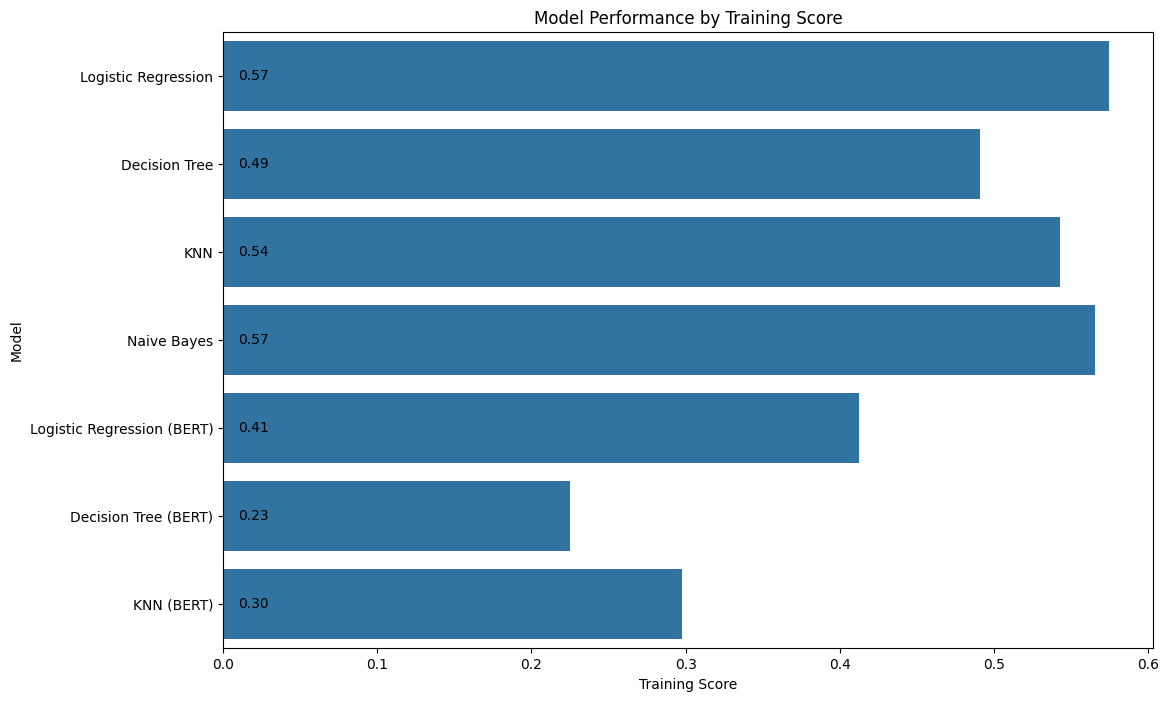

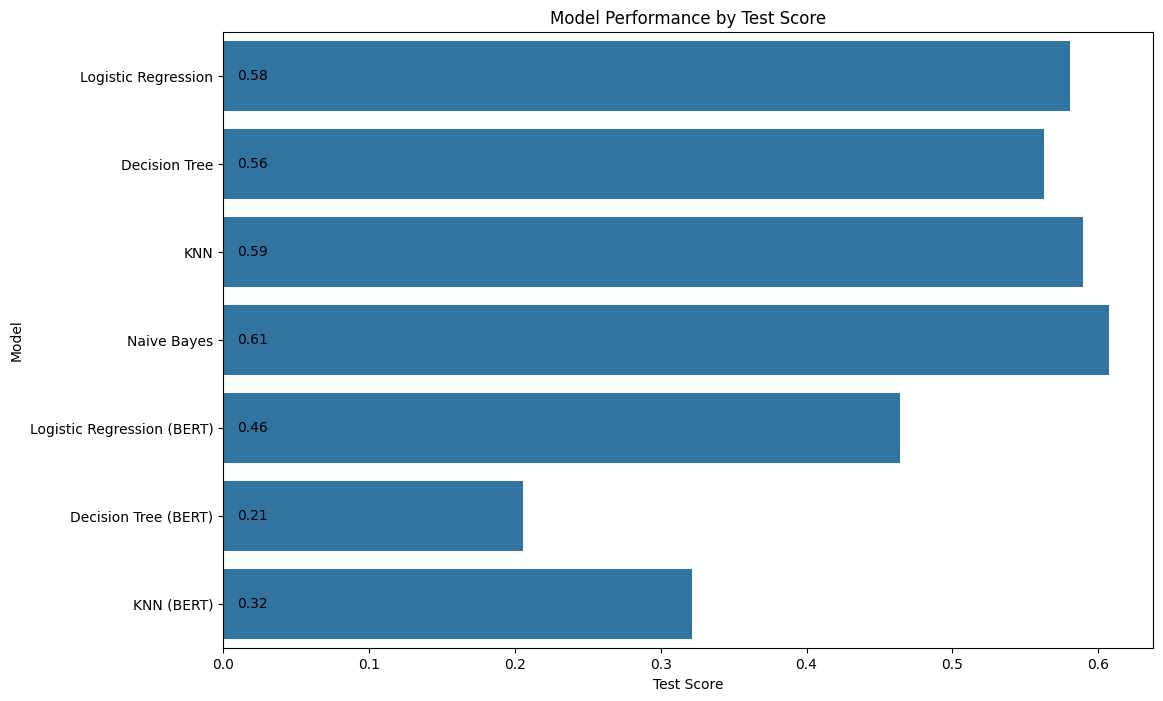

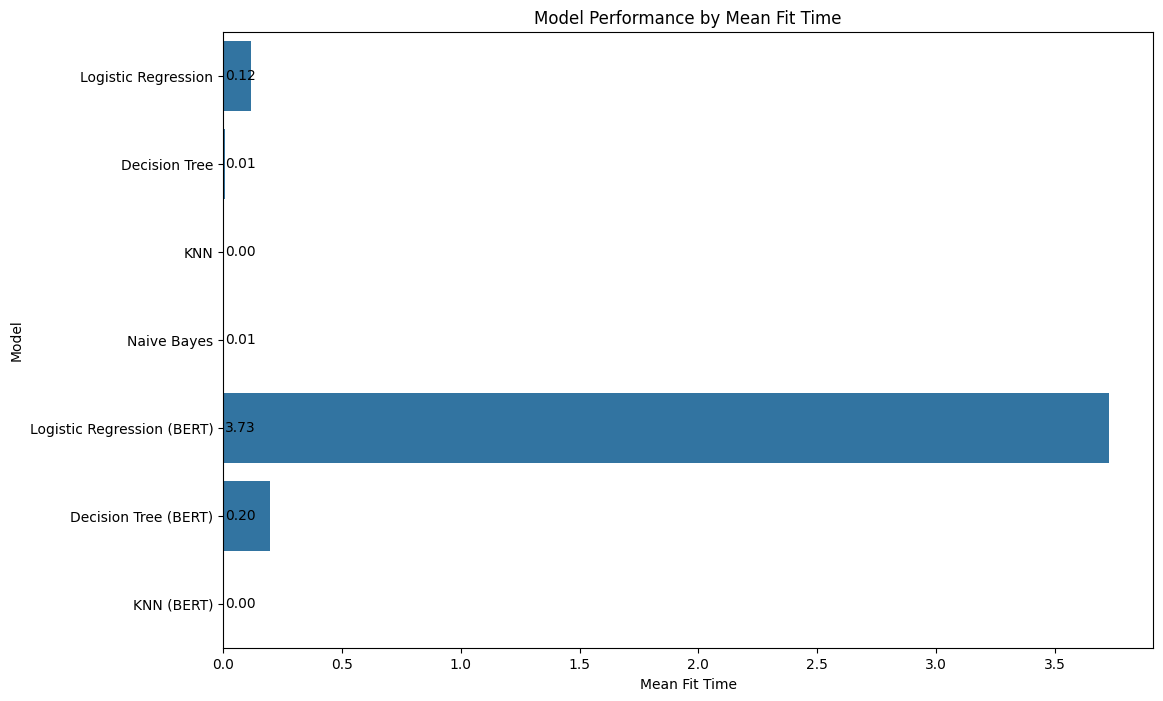

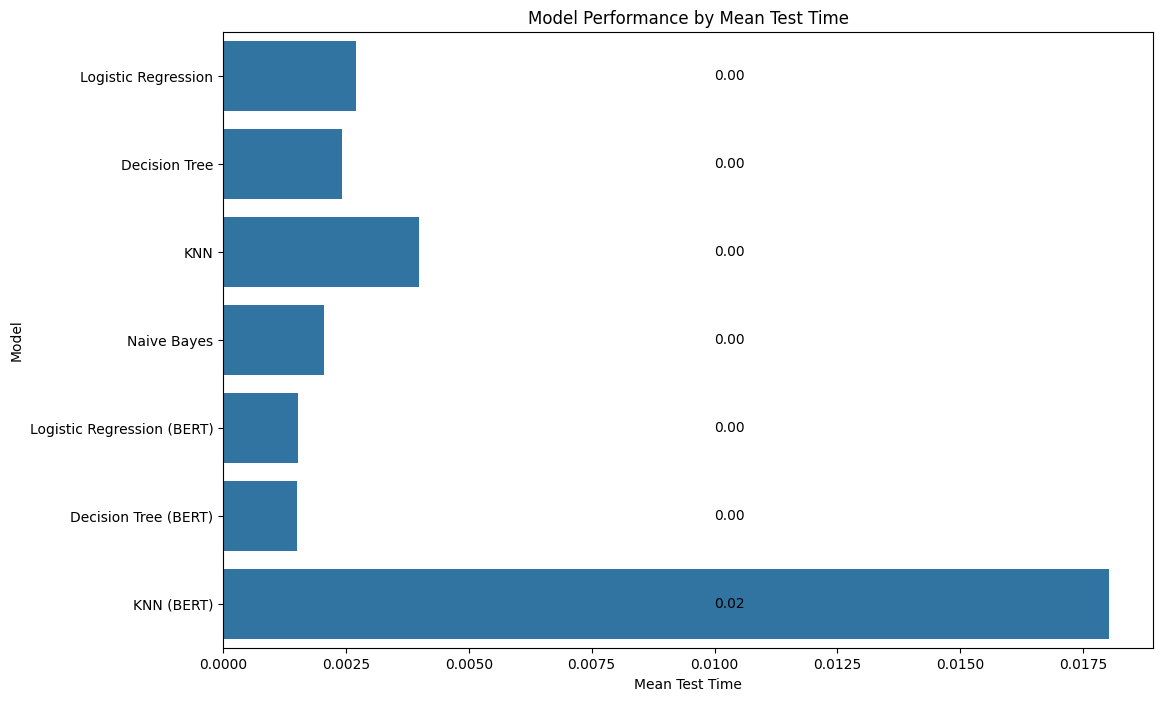

In [9]:
# Plotting the results
import matplotlib.pyplot as plt
import seaborn as sns

for parameter in ['Training Score', 'Test Score', 'Mean Fit Time', 'Mean Test Time']:

    # Set the figure size
    plt.figure(figsize=(12, 8))

    # Create a barplot of the test scores
    sns.barplot(data=merged_results, x=parameter, y=merged_results.index)

    # Add the score values on the bars
    for i in range(merged_results.shape[0]):
        plt.text(0.01, i, f"{merged_results[parameter].iloc[i]:.2f}", va='center')

    # Add labels and title
    plt.xlabel(parameter)
    plt.ylabel('Model')
    plt.title(f'Model Performance by {parameter}')
    plt.show()
